## Conferm that cuda is available

In [ ]:
!pip install -q ultralytics supervision sportslabkit gdown 

In [ ]:
import torch

print("Is CUDA available:", torch.cuda.is_available())
print("Number of CUDA devices:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/workspace/uchida/Tracking_TeamClassification


## Download sample video

In [4]:
!gdown '1k_vKe3fiH1uZL6u9wvE3kpgz_jOIgx4A'

Downloading...
From: https://drive.google.com/uc?id=1k_vKe3fiH1uZL6u9wvE3kpgz_jOIgx4A
To: /home/workspace/uchida/sports/football-analysis-with-gpt4-vision/08fd33_4.mp4
100%|██████████████████████████████████████| 20.3M/20.3M [00:00<00:00, 40.9MB/s]


In [5]:
VIDEO_PATH = os.path.join(HOME, "08fd33_4.mp4")

## Imports

In [6]:
import cv2
import json
import base64
import requests

import numpy as np
import supervision as sv
from typing import List, Optional, Tuple

import sportslabkit as slk
from sportslabkit import Camera
from sportslabkit.mot import BYTETracker
from sportslabkit.matching import MotionVisualMatchingFunction, SimpleMatchingFunction
from sportslabkit.metrics import IoUCMM, CosineCMM, EuclideanCMM


## Helper functions

In [7]:
COLOR_HEX_LIST = [
    "#EE4B2B",
    "#FFFF00",
    "#D3D3D3"
]

def annotate_prompt(
    image: np.ndarray,
    detections: sv.Detections,
    labels: Optional[List[str]] = None
) -> np.ndarray:
    """
    Annotates an image with bounding boxes and labels based on provided detections.

    Parameters:
        image (np.ndarray): The image to be annotated. It should be in a format compatible with sv.BoundingBoxAnnotator
            and sv.LabelAnnotator, typically a NumPy array.
        detections (sv.Detections): A collection of detections, each typically containing information like
            bounding box coordinates, class IDs, etc., to be used for annotation.
        labels (Optional[List[str]]): A list of strings representing the labels for each detection. If not
            provided, labels are automatically generated as sequential numbers.

    Returns:
        np.ndarray: An annotated version of the input image, with bounding boxes and labels drawn over it.

    """
    bounding_box_annotator = sv.BoundingBoxAnnotator(
        color=sv.Color.black(),
        color_lookup=sv.ColorLookup.CLASS)
    label_annotator = sv.LabelAnnotator(
        color=sv.Color.black(),
        text_color=sv.Color.white(),
        color_lookup=sv.ColorLookup.CLASS,
        text_scale=0.7)

    if labels is None:
        labels = [str(i) for i in range(len(detections))]

    annotated_image = image.copy()
    annotated_image = bounding_box_annotator.annotate(
        annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(
        annotated_image, detections=detections, labels=labels)

    return annotated_image


def annotate_result(
    image: np.ndarray,
    detections: sv.Detections
) -> np.ndarray:
    """
    Annotates a given image with ellipses around detected objects.

    Parameters:
        image (np.ndarray): The image to be annotated. It should be in the format
            acceptable by sv.EllipseAnnotator.
        detections (sv.Detections): An object of sv.Detections, which contains
            the detected objects' information to be annotated on the image.

    Returns:
        np.ndarray: An image (numpy array) with ellipses drawn around the detected
            objects. This image is a modified copy of the input image.
    """
    ellipse_annotator = sv.EllipseAnnotator(
        color=sv.ColorPalette.from_hex(color_hex_list=COLOR_HEX_LIST),
        color_lookup=sv.ColorLookup.CLASS,
        thickness=4)

    annotated_image = image.copy()
    annotated_image = ellipse_annotator.annotate(
        annotated_image, detections)
    return annotated_image

## Load detection & Tracking model

In [8]:
conf=0.5
process_noise = 10000
measurement_noise = 10
motion_metric_beta = 0.5
motion_metric_gate = 0.9
visual_metric_beta = 0.5
visual_metric_gate = 0.5

det_model = slk.detection_model.load(
    'yolov8x',
    classes=0, # class index
    device='cuda:0',
    conf = conf,
)
image_model = slk.image_model.load(
    model_name='resnet50',
)

motion_model = slk.motion_model.load(
    model_name='kalmanfilter',
    dt=1/30,
    process_noise=500,
    measurement_noise=10,
    confidence_scaler=1
)

first_matching_fn = MotionVisualMatchingFunction(
    motion_metric=EuclideanCMM(),
    beta=motion_metric_beta,
    motion_metric_gate=motion_metric_gate,
    visual_metric=CosineCMM(),
    visual_metric_gate=visual_metric_gate,
)

second_matching_fn = SimpleMatchingFunction(IoUCMM(), gate=motion_metric_gate)
tracker = BYTETracker(
    detection_model=det_model,
    image_model=image_model,
    motion_model = motion_model,
    first_matching_fn=first_matching_fn,
    second_matching_fn=second_matching_fn,
    detection_score_threshold = conf,
    callbacks=None,
    max_staleness=50,
    min_length=10
)

### execute tracking

In [9]:
#load video
cam = Camera(VIDEO_PATH)
n_frames=100
frames = cam[:n_frames]
#execute tracking
bbdf_pred_player = tracker.track(frames)

#visualize tracking
save_path = './visualize_frames.mp4'
bbdf_pred_player.visualize_frames(VIDEO_PATH, save_path)

Tracking Progress: 100%|██████████| 100/100 [00:39<00:00,  2.55it/s, Active: 23, Dead: 1]
Writing video: 100it [00:02, 37.33it/s]


## Blend images in tracklet


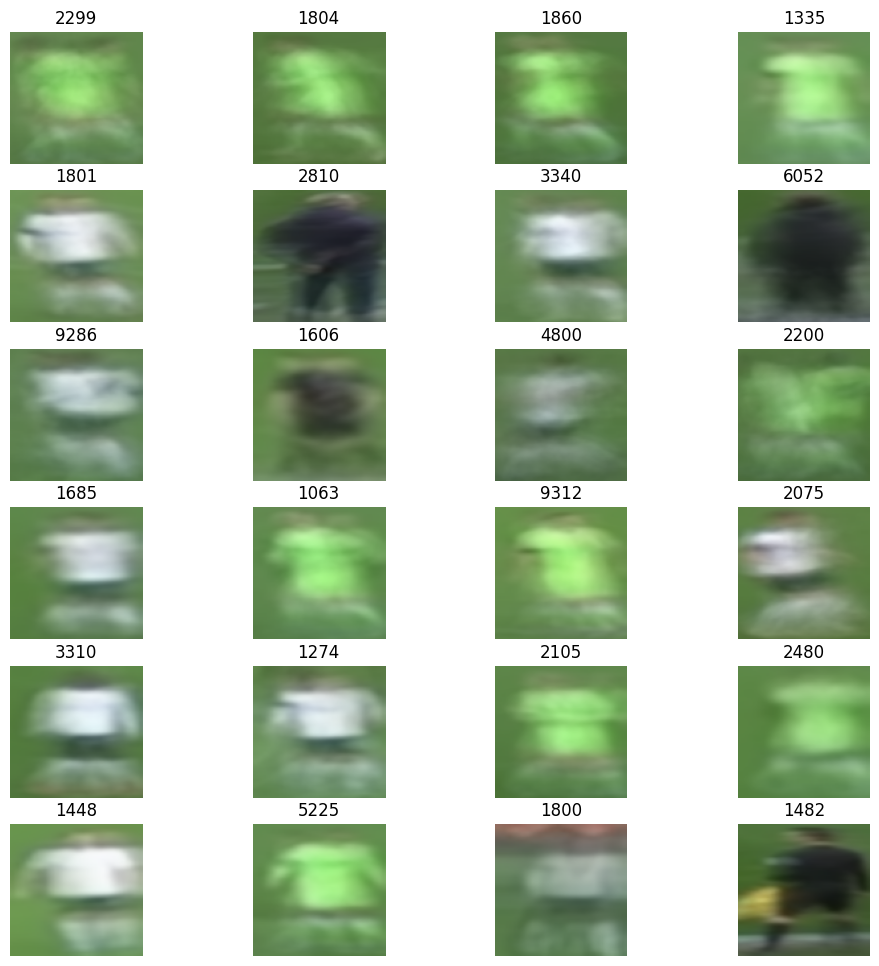

In [11]:

def crop_players(frames: np.ndarray, frame_indices: list, bboxes: list) -> list:
    cropped_images = []
    for frame_index, bbox in zip(frame_indices, bboxes):
        frame = frames[frame_index]
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        x, y, w, h = bbox.astype(int)
        cropped_image = frame[y:y+h, x:x+w]
        cropped_images.append(cropped_image)
    return cropped_images


def resize_images(images: List[np.ndarray], size: Tuple[int, int]) -> List[np.ndarray]:
    """
    Resizes all images to the specified size.

    Args:
        images (List[np.ndarray]): A list of images to be resized. Each image is a 3D NumPy array.
        size (Tuple[int, int]): The target size for the images, specified as (width, height).

    Returns:
        List[np.ndarray]: A list of resized images.
    """
    return [cv2.resize(image, size) for image in images]

def blend_images(images: List[np.ndarray], size: Tuple[int, int]) -> np.ndarray:
    # Ignore empty images
    non_empty_images = [image for image in images if image.size > 0]
    resized_images = [cv2.resize(image, size) for image in non_empty_images]
    if not resized_images:
        # If all images are empty, return an empty image
        return np.zeros((size[1], size[0], 3), dtype=np.uint8)
    blended_image = resized_images[0].astype(float)
    for i, image in enumerate(resized_images[1:100], start=1):
        alpha = 1.0 / (i + 1)
        beta = 1.0 - alpha
        blended_image = cv2.addWeighted(image.astype(float), alpha, blended_image, beta, 0)
    return blended_image

all_tracklets = tracker.alive_tracklets + tracker.dead_tracklets
tracklet_list = []
for tracklet in all_tracklets:
    tracklet_list.append(tracklet)

crops = []
titles = []
# tracklet = tracklet_list[5]
for idx, tracklet in enumerate(tracklet_list):
    cropped_images = crop_players(
        cam, 
        tracklet.get_observations('frame'), 
        tracklet.get_observations('box')
        )
    blended_image = blend_images(cropped_images, size=(100, 100))
    blended_image_uint8 = cv2.convertScaleAbs(blended_image)
    crops.append(blended_image_uint8)
    titles.append(f"{tracklet.id}")

sv.plot_images_grid(crops, titles=titles, grid_size=(6, 4))

## Prompt GPT-4 Vision

In [12]:
OPENAI_API_KEY = "..."
OPENAI_API_URL = "https://api.openai.com/v1/chat/completions"

def encode_image_to_base64(image: np.ndarray) -> str:
    success, buffer = cv2.imencode('.jpg', image)
    if not success:
        raise ValueError("Could not encode image to JPEG format.")

    encoded_image = base64.b64encode(buffer).decode('utf-8')
    return encoded_image


def compose_payload(images: np.ndarray, prompt: str) -> dict:
    text_content = {
        "type": "text",
        "text": prompt
    }
    image_content = [
        {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encode_image_to_base64(image=image)}"
            }
        }
        for image
        in images
    ]
    return {
        "model": "gpt-4-vision-preview",
        "messages": [
            {
                "role": "user",
                "content": [text_content] + image_content
            }
        ],
        "max_tokens": 300
    }


def compose_headers(api_key: str) -> dict:
    return {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }


def prompt_image(api_key: str, images: np.ndarray, prompt: str) -> str:
    headers = compose_headers(api_key=api_key)
    payload = compose_payload(images=images, prompt=prompt)
    response = requests.post(url=OPENAI_API_URL, headers=headers, json=payload).json()

    if 'error' in response:
        raise ValueError(response['error']['message'])
    return response['choices'][0]['message']['content']

### Team assignment based on blended images(small batch)

In [13]:
def chunk_list(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

prompt = (
    "Identify the team of the marked individual in the composite image:"
    "These images are composite and may not have a distinct human shape."
    "However, since the color information in the images approximates the color of the person's uniform,"
    "team information is determined from these color information."
    "The `options are `white` or `neon green`. If the individual in the marked composite image does not belong to either team."
    "(e.g., is a referee, coach, or fan), return `none`. Referees are distinguishable by their black uniforms. "
    "If it is very difficult to determine the classification, please classify based on the color information near the center as much as possible"
    "Coaches and fans should not be considered as team members. "
    "Provide the results in JSON format. The output should include key-value pairs, each representing a bounding box. "
    "Format the output like this: {'0': 'color_1', '1': 'color_2', ...}, "
    "where 'color_1', 'color_2', ... are to be replaced with 'white', 'neon green', or 'none', as applicable. "
    "Use double quotes to enclose property names. "
    "Do not surround the result with backticks (`)"
    "notalk;justgo"
)

batch_size = 10
crop_batches = list(chunk_list(crops, batch_size))
merged_response = {}

for i, batch in enumerate(crop_batches):
    start_index = i * batch_size
    response = prompt_image(api_key=OPENAI_API_KEY, images=batch, prompt=prompt)
    try:
        response_dict = json.loads(response)
        for key, value in response_dict.items():
            merged_response[str(int(key) + start_index)] = value
    except json.JSONDecodeError:
        print(f"Invalid JSON received as response: {response}")

# Create a dictionary mapping index to tracklet ID
index_to_tracklet_id = {i: tracklet.id for i, tracklet in enumerate(tracklet_list)}
# Use this dictionary to convert the keys in the response
merged_response_with_tracklet_id = {index_to_tracklet_id[int(k)]: v for k, v in merged_response.items()}
print(merged_response_with_tracklet_id)

{2299: 'neon green', 1804: 'neon green', 1860: 'neon green', 1335: 'neon green', 1801: 'white', 2810: 'none', 3340: 'white', 6052: 'none', 9286: 'white', 1606: 'none', 4800: 'white', 2200: 'neon green', 1685: 'white', 1063: 'neon green', 9312: 'neon green', 2075: 'white', 3310: 'white', 1274: 'neon green', 2105: 'neon green', 1448: 'white', 5225: 'neon green', 1800: 'white', 1482: 'none'}


In [14]:
# Assign class IDs to the response
def assign_class_ids(response: dict) -> dict:
    color_to_class_id = {'white': 0, 'neon green': 1, 'none': 2}
    class_id_response = {k: color_to_class_id[v] for k, v in response.items()}
    return class_id_response

class_id_response = assign_class_ids(merged_response_with_tracklet_id)
print(class_id_response)

{2299: 1, 1804: 1, 1860: 1, 1335: 1, 1801: 0, 2810: 2, 3340: 0, 6052: 2, 9286: 0, 1606: 2, 4800: 0, 2200: 1, 1685: 0, 1063: 1, 9312: 1, 2075: 0, 3310: 0, 1274: 1, 2105: 1, 1448: 0, 5225: 1, 1800: 0, 1482: 2}


In [15]:
import pandas as pd

# update bbdf and visualize video
for tracklet in tracklet_list:
    try:
        tracklet.team_id = class_id_response[tracklet.id]
    except KeyError:
        tracklet.team_id = 0
update_bbdf = pd.concat([t.to_bbdf() for t in tracklet_list if t.team_id != 2], axis=1).sort_index()

save_path = './visualize_frames_team.mp4'
update_bbdf.visualize_frames(VIDEO_PATH, save_path)

Writing video: 0it [00:00, ?it/s]

Writing video: 100it [00:02, 41.99it/s]
